# Notebook to calculate an average histogram template for the training data used by nnUNet

In [14]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import SimpleITK as sitk
import glob
import pandas as pd
import sys
import torchio as tio
from scipy import stats
from tqdm import tqdm
sys.path.append('../..')
from src.skmtea_utils import *

## Nyul Method First

In [2]:
raw_data_path = '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/imagesTr/'
save_path = '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/'

files = glob.glob(raw_data_path + '*')

In [3]:
files.sort()
print('Number of files:', len(files))
files[:5]

Number of files: 148


['../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/imagesTr/IWOAI_001_0000.nii.gz',
 '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/imagesTr/IWOAI_002_0000.nii.gz',
 '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/imagesTr/IWOAI_003_0000.nii.gz',
 '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/imagesTr/IWOAI_004_0000.nii.gz',
 '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/imagesTr/IWOAI_005_0000.nii.gz']

In [3]:
# compute Nyul landmarks of the training set
#landmarks = tio.transforms.HistogramStandardization.train(files, cutoff=(0, 99.8/100), output_path=save_path + 'nyul_landmarks.npy')

  0%|          | 0/148 [00:00<?, ?it/s]

In [4]:
# load landmarks
landmarks = np.load(save_path + 'nyul_landmarks.npy')

In [5]:
landmarks

array([  0.        ,   8.94793685,  11.56007917,  12.79053736,
        14.03658842,  16.7549062 ,  19.97616642,  24.1696531 ,
        30.52758678,  35.02680085,  40.63938225,  53.68541308,
       100.        ])

### Have a go at transforming one image

In [6]:
subjects = []

for image_path in files:
    subject = tio.Subject(
        mri=tio.ScalarImage(image_path),
    )
    subjects.append(subject)

dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 148 subjects


In [7]:
example = dataset[0]

In [8]:
landmarks_dict = {'mri': landmarks}
histogram_transform = tio.HistogramStandardization(landmarks_dict)

transformed = histogram_transform(example)


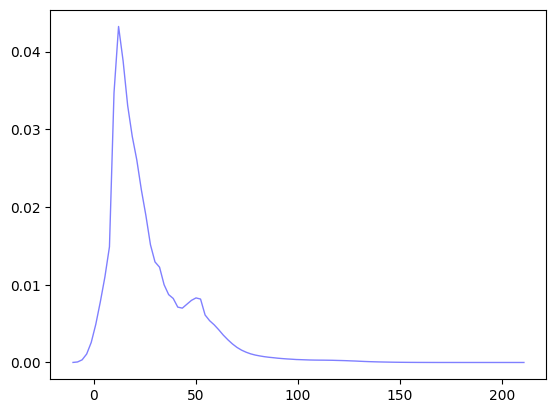

In [9]:
# plot before and after
def plot_histogram(axis, values, num_positions=100, label=None, alpha=0.05, color=None):
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

fig, ax = plt.subplots()
#plot_histogram(ax, example.mri.data, label='Original', alpha=0.5, color='red')
plot_histogram(ax, transformed.mri.data.numpy().ravel(), label='Standardized', alpha=0.5, color='blue')

### Plot all the histograms for the train data before and after the transformation

100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [01:51<00:00,  1.33it/s]


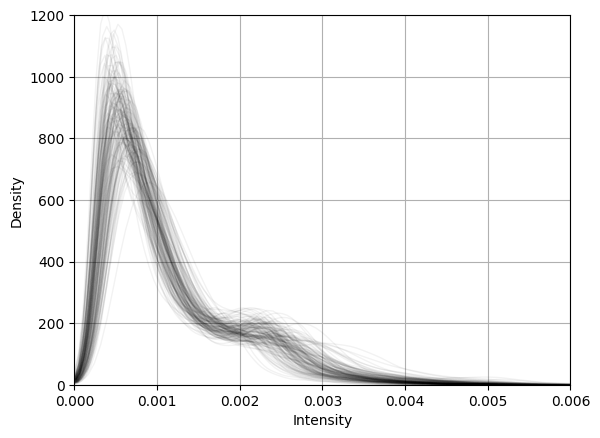

In [63]:
fig, ax = plt.subplots(dpi=100)
for path in tqdm(files):
    tensor = tio.ScalarImage(path).data
    values = tensor.numpy().ravel()

    # get sample of values
    sample = np.random.choice(values, 100000)
    plot_histogram(ax, sample)

ax.set_xlabel('Intensity')
ax.set_ylabel('Density')
ax.set_xlim(0, 0.006)
ax.set_ylim(0, 1200)
ax.grid()
plt.savefig('iwoai_histograms.pdf', format='pdf', bbox_inches='tight')

100%|████████████████████████████████████████████████████████████████████████████████| 148/148 [02:41<00:00,  1.09s/it]


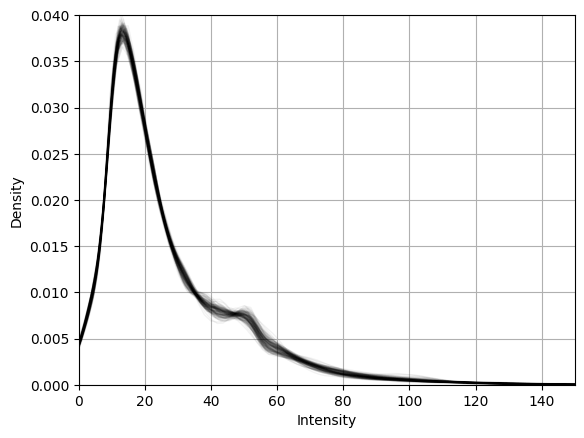

In [64]:
fig, ax = plt.subplots(dpi=100)
for path in tqdm(files):
    image = sitk.ReadImage(path)
    image = sitk.GetArrayFromImage(image)

    # turn to tio subject
    sample = tio.Subject(
        mri=tio.ScalarImage(tensor=np.expand_dims(image, axis=0))
    )

    standard = histogram_transform(sample)
    tensor = standard.mri.data
    values = tensor.numpy().ravel()

    # get sample of values
    sample = np.random.choice(values, 100000)
    plot_histogram(ax, sample)

ax.set_xlabel('Intensity')
ax.set_ylabel('Density')
ax.set_xlim(0, 150)
ax.set_ylim(0, 0.04)
ax.grid()
plt.savefig('iwoai_transformed_histograms.pdf', format='pdf', bbox_inches='tight')

In [16]:
# attempt to transform one image when read in as a numpy array
image = sitk.ReadImage(files[0])
image = sitk.GetArrayFromImage(image)
image = image.astype(np.float32)
print(image.shape)

# turn image into tio subject
subject = tio.Subject(
    mri=tio.ScalarImage(tensor=np.expand_dims(image, axis=0))
)

# transform
transformed = histogram_transform(subject)

transformed_np = transformed.mri.data.numpy()

print(transformed_np.shape)

(160, 200, 256)
(1, 160, 200, 256)


### Now let's plot SKM-TEA

In [11]:
skmtea_path = '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/images_all_skmtea/'
skmtea_files = glob.glob(skmtea_path + '*')

In [12]:
skmtea_files.sort()
print('Number of files:', len(skmtea_files))
skmtea_files[:5]

Number of files: 155


['../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/images_all_skmtea/SKMTEA_001_0000.nii.gz',
 '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/images_all_skmtea/SKMTEA_002_0000.nii.gz',
 '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/images_all_skmtea/SKMTEA_003_0000.nii.gz',
 '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/images_all_skmtea/SKMTEA_004_0000.nii.gz',
 '../../../nnUNet_data/nnUNet_raw/Dataset361_Menisci/images_all_skmtea/SKMTEA_005_0000.nii.gz']

100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [03:28<00:00,  1.35s/it]


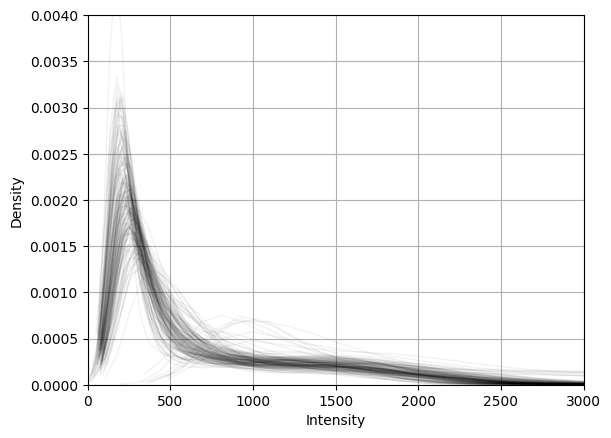

In [67]:
# plot skmtea histograms
fig, ax = plt.subplots()
for path in tqdm(skmtea_files):
    image = sitk.ReadImage(path)
    image = sitk.GetArrayFromImage(image)
    values = image.ravel()

    # get sample of values
    sample = np.random.choice(values, 100000)
    plot_histogram(ax, sample)

ax.set_xlabel('Intensity')
ax.set_ylabel('Density')
ax.set_xlim(0,3000)
ax.set_ylim(0,0.004)
ax.grid()
plt.savefig('skmtea_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

  0%|                                                                                          | 0/155 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [04:25<00:00,  1.71s/it]


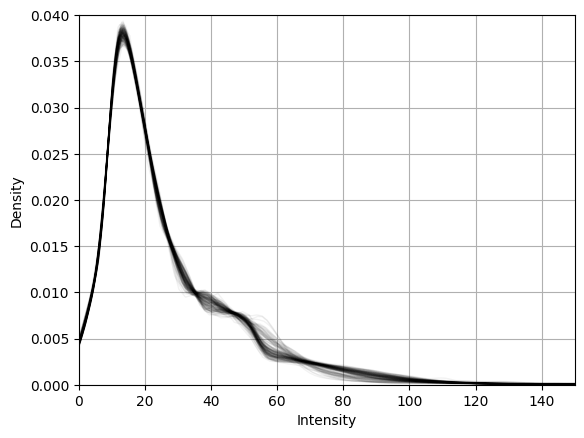

In [68]:
# plot transformed skmtea histograms
fig, ax = plt.subplots(dpi=100)
for path in tqdm(skmtea_files):
    image = sitk.ReadImage(path)
    image = sitk.GetArrayFromImage(image)

    # turn to tio subject
    sample = tio.Subject(
        mri=tio.ScalarImage(tensor=np.expand_dims(image, axis=0))
    )

    standard = histogram_transform(sample)
    tensor = standard.mri.data
    values = tensor.numpy().ravel()

    # get sample of values
    sample = np.random.choice(values, 100000)
    plot_histogram(ax, sample)

ax.set_xlabel('Intensity')
ax.set_ylabel('Density')
ax.set_xlim(0, 150)
ax.set_ylim(0, 0.04)
ax.grid()
plt.savefig('skmtea_transformed_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 155/155 [04:37<00:00,  1.79s/it]


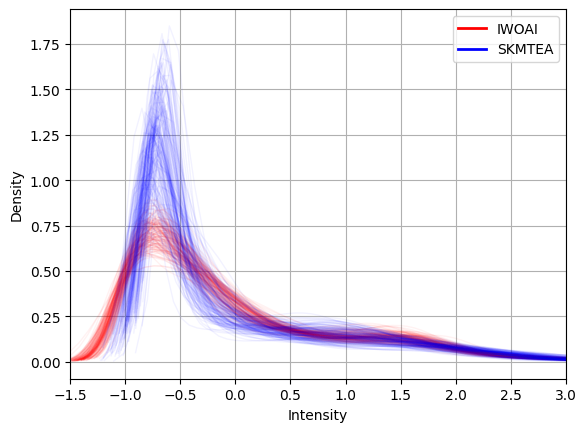

In [15]:
from src.utils import z_score_norm
import matplotlib.lines as mlines

# plot both datasets after z-score normalization
fig, ax = plt.subplots(dpi=100)
for path in tqdm(files):
    image = sitk.ReadImage(path)
    image = sitk.GetArrayFromImage(image)
    image = z_score_norm(image)
    values = image.ravel()

    # get sample of values
    sample = np.random.choice(values, 100000)
    plot_histogram(ax, sample, color='red', label='IWOAI')

for path in tqdm(skmtea_files):
    image = sitk.ReadImage(path)
    image = sitk.GetArrayFromImage(image)
    image = z_score_norm(image)
    values = image.ravel()

    # get sample of values
    sample = np.random.choice(values, 100000)
    plot_histogram(ax, sample, color='blue', label='SKMTEA')

ax.set_xlabel('Intensity')
ax.set_ylabel('Density')
ax.set_xlim(-1.5,3)

# Create solid-line legend handles
legend_lines = [
    mlines.Line2D([], [], color='red', label='IWOAI', linewidth=2, alpha=1.0),
    mlines.Line2D([], [], color='blue', label='SKMTEA', linewidth=2, alpha=1.0)
]

ax.legend(handles=legend_lines)
ax.grid()
plt.savefig('z_score_all_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 155/155 [08:45<00:00,  3.39s/it]


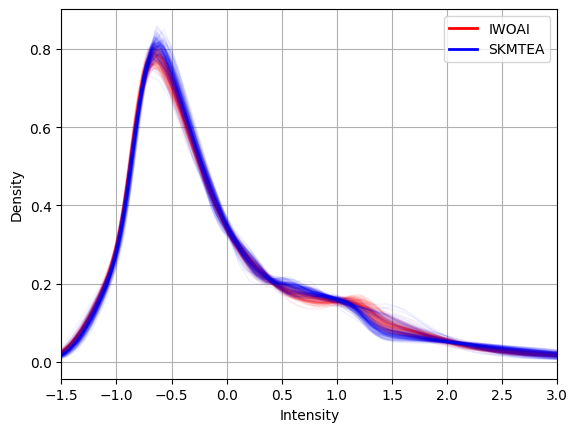

In [17]:
# plot both datasets after histogram standardization and z-score normalization
fig, ax = plt.subplots(dpi=100)
for path in tqdm(files):
    image = sitk.ReadImage(path)
    image = sitk.GetArrayFromImage(image)
    image = image.astype(np.float32)
    subject = tio.Subject(
        mri=tio.ScalarImage(tensor=np.expand_dims(image, axis=0))
    )
    transformed = histogram_transform(subject)
    values = transformed.mri.data.numpy().ravel()
    values = z_score_norm(values)

    # get sample of values
    sample = np.random.choice(values, 100000)
    plot_histogram(ax, sample, color='red')

for path in tqdm(skmtea_files):
    image = sitk.ReadImage(path)
    image = sitk.GetArrayFromImage(image)
    image = image.astype(np.float32)
    subject = tio.Subject(
        mri=tio.ScalarImage(tensor=np.expand_dims(image, axis=0))
    )
    transformed = histogram_transform(subject)
    values = transformed.mri.data.numpy().ravel()
    values = z_score_norm(values)

    # get sample of values
    sample = np.random.choice(values, 100000)
    plot_histogram(ax, sample, color='blue')

# Create solid-line legend handles
legend_lines = [
    mlines.Line2D([], [], color='red', label='IWOAI', linewidth=2, alpha=1.0),
    mlines.Line2D([], [], color='blue', label='SKMTEA', linewidth=2, alpha=1.0)
]

ax.legend(handles=legend_lines)
ax.grid()
ax.set_xlabel('Intensity')
ax.set_ylabel('Density')
ax.set_xlim(-1.5,3)
plt.savefig('transformed_all_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Now make full cdf template

In [3]:
# path to preprocessed data
data_path = '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres'
save_path = '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/'

# Get all the files in the data path
files = glob.glob(data_path + '/*')

In [4]:
files.sort()
print('Number of files:', len(files))
files[:5]

Number of files: 592


['../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_001.npy',
 '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_001.npz',
 '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_001.pkl',
 '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_001_seg.npy',
 '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_002.npy']

In [5]:
# only need the images (not masks) - files ending with .npy but not with _seg.npy
images = [f for f in files if f.endswith('.npy') and not f.endswith('_seg.npy')]
print('Number of images:', len(images))
images[:5]

Number of images: 148


['../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_001.npy',
 '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_002.npy',
 '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_003.npy',
 '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_004.npy',
 '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/nnUNetPlans_3d_fullres/IWOAI_005.npy']

Image shape: (1, 160, 200, 256)


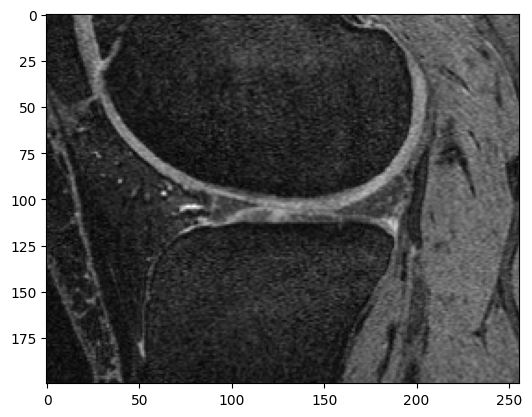

In [6]:
# show slice of first image to check
img = np.load(images[0])
print('Image shape:', img.shape)
plt.imshow(img[0,100,...], cmap='gray')

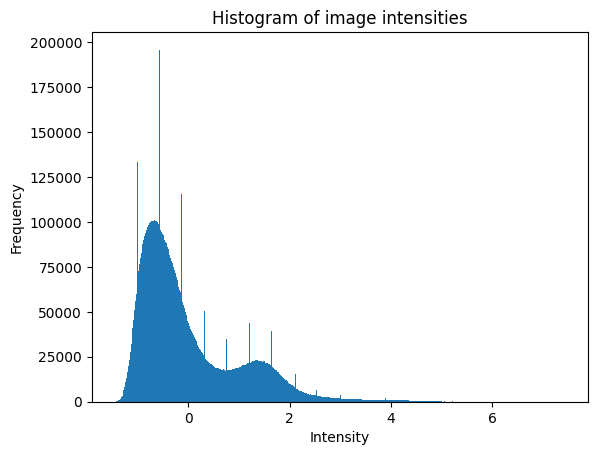

In [36]:
# plot histogram of first image
plt.hist(img.flatten(), bins=500)
plt.ylabel('Frequency')
plt.xlabel('Intensity')
plt.title('Histogram of image intensities')
plt.show()

In [37]:
# 99.7 percentile of intensities in both directions
min = np.percentile(img, 0.15)
max = np.percentile(img, 99.85)
print('Min:', min)
print('Max:', max)

Min: -1.289245367050171
Max: 4.446145057678223


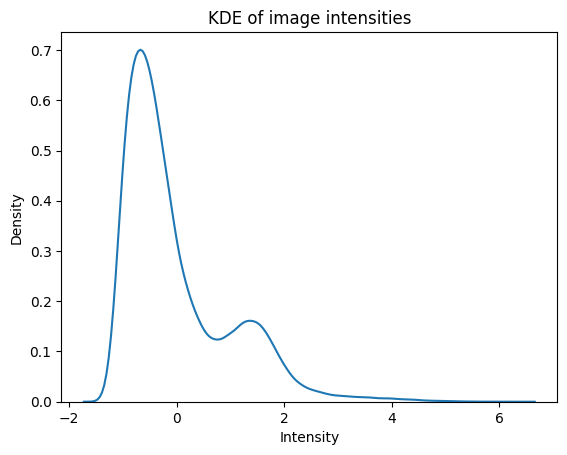

In [38]:
# plot kde of first image
# take smaller random sample
sample = np.random.choice(img.flatten(), 100000)
sns.kdeplot(sample)
plt.ylabel('Density')
plt.xlabel('Intensity')
plt.title('KDE of image intensities')
plt.show()

## Cycle Through Each Image, saving histogram (500 bins) and getting average template

In [22]:
# first find the range of intensities for all images
min_intensity = np.inf
max_intensity = -np.inf

for i in range(len(images)):
    img = np.load(images[i])
    min_i = img.min()
    max_i = img.max()
    if min_i < min_intensity:
        min_intensity = min_i
    if max_i > max_intensity:
        max_intensity = max_i

print('Min intensity:', min_intensity)
print('Max intensity:', max_intensity)

Min intensity: -1.7830299
Max intensity: 10.026568


In [40]:
# choose range as -2 to 10
intensity_range = (-2, 10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:15<00:00,  9.35it/s]


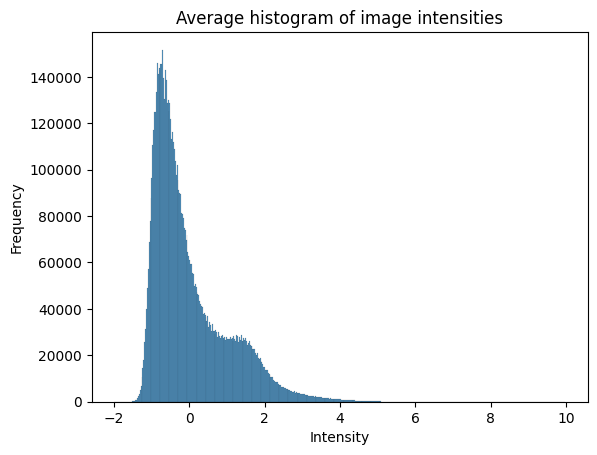

In [45]:
# Get average histogram of all images
# initialize average histogram
num_bins = 500
avg_hist = np.zeros(num_bins)
bin_edges = np.linspace(intensity_range[0], intensity_range[1], num_bins+1)

# loop through all images, using tqdm to keep track of progress
import tqdm
for i in tqdm.tqdm(range(len(images))):
    # load image
    img = np.load(images[i])
    # get histogram
    hist, _ = np.histogram(img.flatten(), bins=num_bins, range=intensity_range)
    # add to average histogram
    avg_hist += hist

# normalize average histogram
avg_hist = avg_hist / len(images)

# get bin centres for plotting
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

# plot average histogram, using sns and overlaying kde
sns.histplot(weights=avg_hist, bins=num_bins, x=bin_centres)
plt.ylabel('Frequency')
plt.xlabel('Intensity')
plt.title('Average histogram of image intensities')
plt.show()

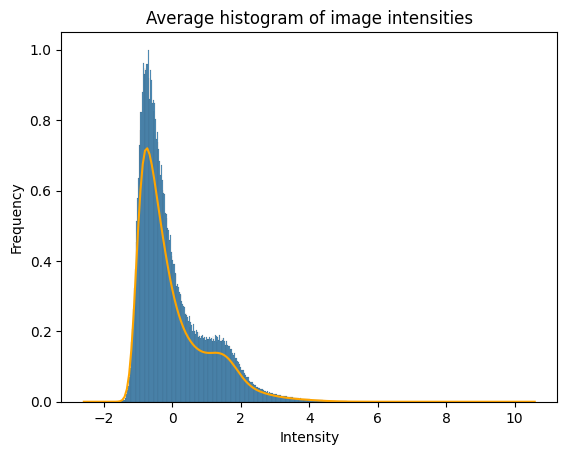

In [56]:
# plot hist of average histogram
sns.histplot(weights=(avg_hist/np.max(avg_hist)), bins=num_bins, x=bin_centres)
# plot kde of average histogram
sns.kdeplot(x=bin_centres, weights=avg_hist, bw_adjust=0.2, color='orange')

plt.ylabel('Frequency')
plt.xlabel('Intensity')
plt.title('Average histogram of image intensities')
plt.show()

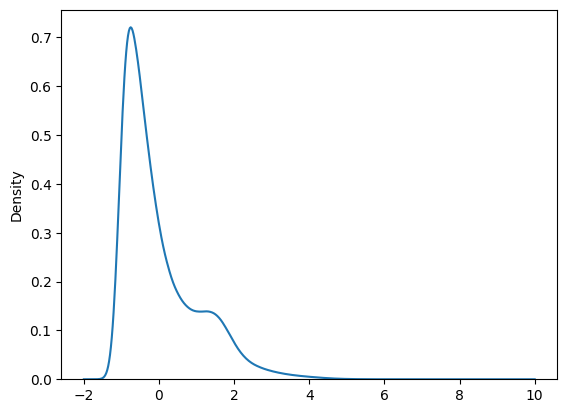

In [55]:
values = sns.kdeplot(x=bin_centres, weights=avg_hist, bw_adjust=0.2, gridsize=num_bins+1, clip=intensity_range).get_lines()[0].get_data()

In [57]:
values[0].shape

(501,)

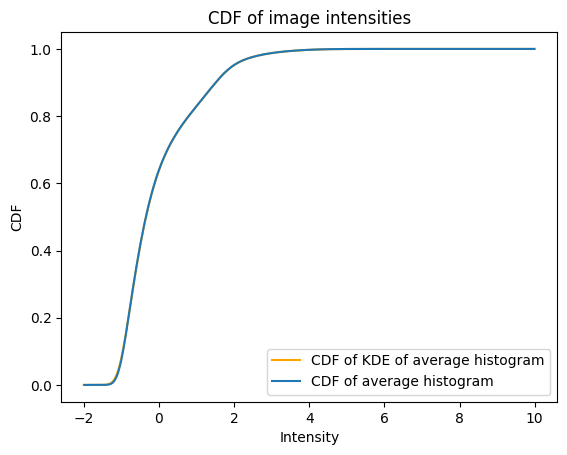

In [61]:
# cdf of kde of average histogram
av_cdf = np.cumsum(values[1]) / sum(values[1])
plt.plot(values[0], av_cdf, color='orange', label='CDF of KDE of average histogram')

# also plot the cdf of the average histogram
cdf_hist = np.cumsum(avg_hist) / sum(avg_hist)
plt.plot(bin_centres, cdf_hist, label='CDF of average histogram')

plt.ylabel('CDF')
plt.xlabel('Intensity')
plt.title('CDF of image intensities')
plt.legend()
plt.show()

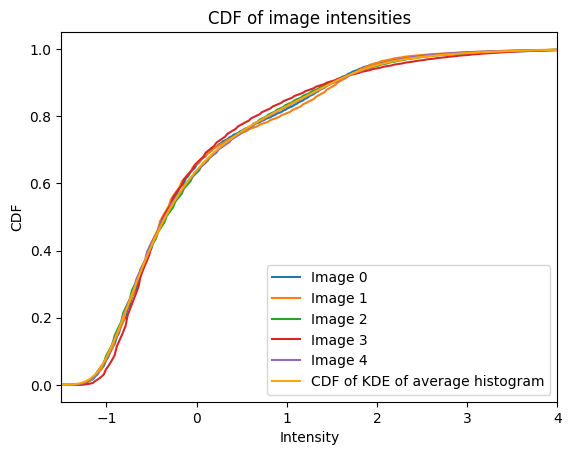

In [69]:
# plot cdf of first 5 images and the template cdf

for i in range(5):
    img = np.load(images[i])
    hist, _ = np.histogram(img.flatten(), bins=num_bins, range=intensity_range)
    cdf = np.cumsum(hist) / sum(hist)
    plt.plot(bin_centres, cdf, label='Image ' + str(i))

plt.plot(values[0], av_cdf, color='orange', label='CDF of KDE of average histogram')
plt.legend()
plt.ylabel('CDF')
plt.xlabel('Intensity')
plt.xlim(-1.5,4)
plt.title('CDF of image intensities')
plt.show()

In [91]:
def match_histogram_3d(image, template_cdf, num_bins=500, intensity_range=(-2, 10)):
    """
    Match the histogram of a 3D image to a template histogram (with given number of bins).
    """
    # Flatten the 3D image into a 1D array
    img_flat = image.flatten()

    # Compute the histogram and CDF for the input image
    img_hist, img_bin_edges = np.histogram(img_flat, bins=num_bins, range=intensity_range)
    img_cdf = np.cumsum(img_hist) / img_hist.sum()

    # Create a mapping from the image CDF to the template CDF
    mapping = np.interp(img_cdf, template_cdf, img_bin_edges)

    # Apply the mapping to the flattened image
    img_matched_flat = np.interp(img_flat, img_bin_edges[:-1], mapping)

    # Reshape the matched image back to its original 3D shape
    img_matched = img_matched_flat.reshape(image.shape)
    
    return img_matched

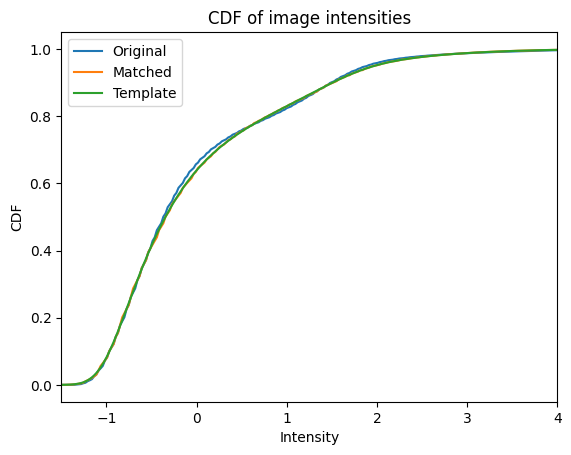

In [ ]:
img = np.load(images[0])
matched = match_histogram_3d(img, av_cdf)

# plot cdfs of original, matched and template
img_flat = img.flatten()
img_matched_flat = matched.flatten()

img_hist, img_bin_edges = np.histogram(img_flat, bins=num_bins, range=intensity_range)
img_cdf = np.cumsum(img_hist) / img_hist.sum()

matched_hist, matched_bin_edges = np.histogram(img_matched_flat, bins=num_bins, range=intensity_range)
matched_cdf = np.cumsum(matched_hist) / matched_hist.sum()

plt.plot(img_bin_edges[:-1], img_cdf, label='Original')
plt.plot(matched_bin_edges[:-1], matched_cdf, label='Matched')
plt.plot(values[0], av_cdf, label='Template')
plt.ylabel('CDF')
plt.xlabel('Intensity')
plt.xlim(-1.5,4)
plt.title('CDF of image intensities')
plt.legend()
plt.show()

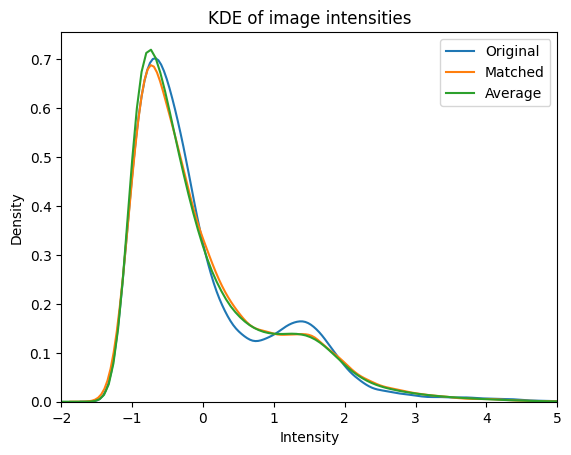

In [76]:
# plot kdes of original and matched images, as well as the histogram of the template image
sample = np.random.choice(img.flatten(), 100000)
sns.kdeplot(sample, label='Original')
sample_matched = np.random.choice(matched.flatten(), 100000)
sns.kdeplot(sample_matched, label='Matched')
sns.kdeplot(x=bin_centres, weights=avg_hist, bw_adjust=0.2, label='Average')
plt.ylabel('Density')
plt.xlim(-2, 5)
plt.xlabel('Intensity')
plt.title('KDE of image intensities')
plt.legend()
plt.show()

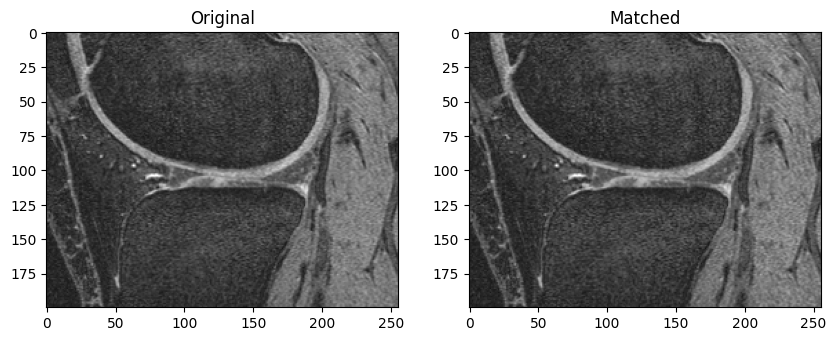

In [77]:
# plot slices of original and matched images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[0,100,...], cmap='gray', vmin=-2, vmax=5)
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(matched[0,100,...], cmap='gray', vmin=-2, vmax=5)
plt.title('Matched')
plt.show()

In [83]:
# Save the template CDF to a file
np.save(save_path + 'zscore_template_train_cdf.npy', av_cdf)

# Do same with CLAHE images - make template

In [86]:
clahe_path = '../../../nnUNet_data/nnUNet_preprocessed/Dataset361_Menisci/3d_fullres_clahe'

In [87]:
def get_file_paths(data_path):
    """
    Get the file paths for all the images in the data path.
    """
    # Get all the files in the data path
    files = glob.glob(data_path + '/*')
    files.sort()

    # Only need the images (not masks) - files ending with .npy but not with _seg.npy
    images = [f for f in files if f.endswith('.npy') and not f.endswith('_seg.npy')]
    
    return images

In [88]:
clahe_images = get_file_paths(clahe_path)

In [92]:
# check range of intensities in clahe images
min_intensity = np.inf
max_intensity = -np.inf

for i in range(len(clahe_images)):
    img = np.load(clahe_images[i])
    min_i = img.min()
    max_i = img.max()
    if min_i < min_intensity:
        min_intensity = min_i
    if max_i > max_intensity:
        max_intensity = max_i

print('Min intensity:', min_intensity)
print('Max intensity:', max_intensity)

Min intensity: 0.0
Max intensity: 1.0


In [93]:
# choose range
intensity_range = (0, 1)

In [97]:
# make template cdf
def get_data_template(images, intensity_range, num_bins=500):
    """
    Get the template CDF for the data.
    """
    # Initialize average histogram
    avg_hist = np.zeros(num_bins)
    bin_edges = np.linspace(intensity_range[0], intensity_range[1], num_bins+1)

    # Loop through all images
    for i in tqdm.tqdm(range(len(images))):
        # Load image
        img = np.load(images[i])
        # Get histogram
        hist, _ = np.histogram(img.flatten(), bins=num_bins, range=intensity_range)
        # Add to average histogram
        avg_hist += hist

    # Normalize average histogram
    avg_hist = avg_hist / len(images)

    # Get bin centres for plotting
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Get KDE of average histogram
    values = sns.kdeplot(x=bin_centres, weights=avg_hist, bw_adjust=0.2, gridsize=num_bins+1, clip=intensity_range).get_lines()[0].get_data()

    # Get CDF of KDE of average histogram
    av_cdf = np.cumsum(values[1]) / sum(values[1])
    
    return avg_hist, av_cdf

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [01:09<00:00,  2.12it/s]


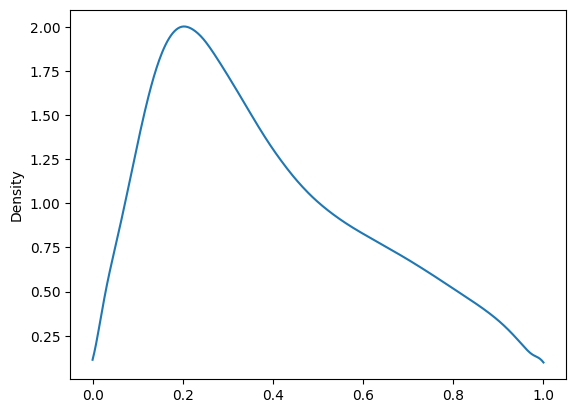

In [98]:
# get clahe template cdf
clahe_template_hist, clahe_template_cdf = get_data_template(clahe_images, intensity_range)

Text(0.5, 1.0, 'Histogram and CDF of CLAHE image intensities')

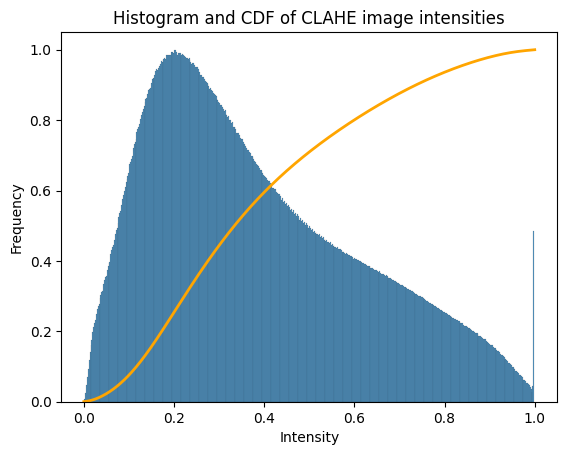

In [104]:
# plot clahe histogram and cdf
bin_edges = np.linspace(0, 1, 501)
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
sns.histplot(weights=(clahe_template_hist) / np.max(clahe_template_hist), bins=500, x=bin_centres, label='Histogram')
plt.plot(bin_edges, clahe_template_cdf, label='CDF', color='orange', lw=2)
plt.ylabel('Frequency')
plt.xlabel('Intensity')
plt.title('Histogram and CDF of CLAHE image intensities')

In [108]:
# Save the template clahe CDF to a file
np.save(save_path + 'clahe_template_train_cdf.npy', clahe_template_cdf)

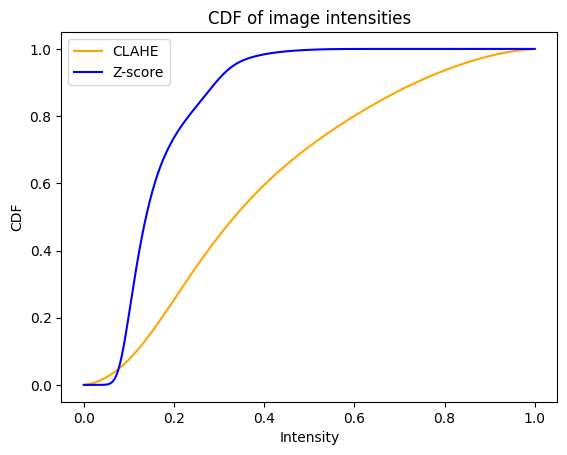

In [106]:
# clahe cdf vs zscore cdf
plt.plot(bin_edges, clahe_template_cdf, label='CLAHE', color='orange')
plt.plot(bin_edges, av_cdf, label='Z-score', color='blue')
plt.ylabel('CDF')
plt.xlabel('Intensity')
plt.title('CDF of image intensities')
plt.legend()